# OpenCV的照相机三维重建

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
import cv2
from mpl_toolkits import mplot3d
from itertools import product, combinations
from plotlyhelp import init_plotly_online_mode
init_plotly_online_mode()

本文介绍下面两个函数的使用方法:

* `triangulatePoints(Rt1, Rt2, points1, points2)`
* `findFundamentalMat(points1, points2, ...)`
* `findEssentialMat(points1, points2, ...)`
* `decomposeEssentialMat(E)`
* `recoverPose(E, points1, points2, A)`

三维空间中的点的坐标通过下面的公式映射到照相机中的像素:

$$s \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
= 
\begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} r_{11} & r_{12} & r_{13} & t_1 \\ r_{21} & r_{22} & r_{23} & t_2 \\ r_{31} & r_{32} & r_{33} & t_3 \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}$$

* $(X, Y, Z)$是三维空间中的某点坐标。
* $r, t$构成的矩阵$[R|t]$是旋转偏移矩阵，通过该矩阵将点转换为与照相机对齐的坐标系中。
* $f_x, f_y$是照相机的焦距。
* $c_x, c_y$是照相机的图像的中心。
* $(u, v)$是点$(X, Y, Z)$在照相机的图片中对应的像素坐标。
* $s$是一个常数。

## 立方体投影到照相机的图像上

首先创建立方体各个边上的点。照相机位于坐标原点，面向Z轴的正方向。

In [2]:
points = []
vertexs = list(product([-1, 1], [-1, 1], [-1, 1]))
for v1, v2 in combinations(vertexs, 2):
    dist = np.sum(np.subtract(v1, v2)**2)**0.5
    if dist > 2.1:
        continue
    points.append(np.column_stack([np.linspace(v1[i], v2[i], 10) for i in range(3)]))
points = np.vstack(points)    
points = np.array(list(set(tuple(p) for p in points.tolist())))
points = points.T
points *= 100
points[2] += 300

In [3]:
def plot_points(points):
    from plotly.offline import iplot
    import plotly.graph_objs as go
    
    x, y, z = points[:3]

    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(size=3)
    )

    data = [trace1]
    layout = go.Layout(
        margin=dict(l=0, r=0, b=0, t=0)
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

plot_points(points)

下面是一些帮助函数:

* `homogeneous(x)`：将坐标转换为齐次坐标
* `camera_matrix()`：计算照相机的旋转矩阵
* `rot_matrix()`：使用下面的公式计算旋转矩阵

$${\displaystyle {\begin{alignedat}{1}R_{x}(\theta )&={\begin{bmatrix}1&0&0\\0&\cos \theta &-\sin \theta \\[3pt]0&\sin \theta &\cos \theta \\[3pt]\end{bmatrix}}\\[6pt]R_{y}(\theta )&={\begin{bmatrix}\cos \theta &0&\sin \theta \\[3pt]0&1&0\\[3pt]-\sin \theta &0&\cos \theta \\\end{bmatrix}}\\[6pt]R_{z}(\theta )&={\begin{bmatrix}\cos \theta &-\sin \theta &0\\[3pt]\sin \theta &\cos \theta &0\\[3pt]0&0&1\\\end{bmatrix}}\end{alignedat}}}$$

In [4]:
def homogeneous(x):
    x = np.asarray(x)
    if x.ndim == 1:
        return np.r_[x, 1]
    else:
        return np.vstack([x, np.ones(x.shape[1])])
    
def camera_matrix(f, cx, cy):
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0,  1]], dtype=float)

def plot_pixels(pixels, width=640, height=480):
    fig, ax = pl.subplots()
    ax.set_aspect("equal")
    rect = pl.Rectangle((0, 0), 640, 480, fill=False, ls="--")
    ax.add_patch(rect)
    ax.axis("off")
    ax.plot(pixels[0], pixels[1], "s", ms=1)
    return fig, ax

def rot_matrix(theta, axis):
    c = np.cos(theta)
    s = np.sin(theta)
    m = np.array([[c, -s], [s, c]])
    m2 = np.insert(np.insert(m, axis, 0, axis=0), axis, 0, axis=1)
    m2[axis, axis] = 1
    if axis == 1:
        m2 = m2.T
    return m2

下面将点云映射到照相机的照片上。第一个照相机的的旋转偏移矩阵为标准矩阵：

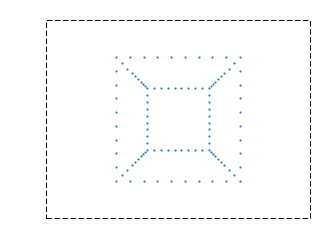

In [5]:
Rt1 = np.column_stack([np.eye(3), np.zeros(3)])
A1 = camera_matrix(300, 320, 240)
A1_inv = np.linalg.inv(A1)
pixels1 = A1 @ Rt1 @ homogeneous(points)
pixels1 /= pixels1[2]
plot_pixels(pixels1);

第二个照相机绕Y轴旋转20度，并且在X-Y平面上偏移(-30, -10)。两个照相机的照相机矩阵相同。

[[  0.93969262   0.           0.34202014 -30.        ]
 [  0.           1.           0.         -10.        ]
 [ -0.34202014   0.           0.93969262   0.        ]]


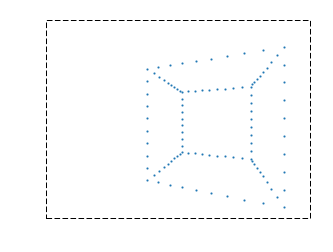

In [6]:
Rt2 = np.column_stack([rot_matrix(np.deg2rad(20), 1), [-30, -10, 0]])
print(Rt2)
A2 = A1
A2_inv = np.linalg.inv(A2)
pixels2 = A2 @ Rt2 @ homogeneous(points)
pixels2 /= pixels2[2]
pixels_normal2 = A2_inv @ pixels2
plot_pixels(pixels2);

照相机矩阵的逆矩阵与像素坐标乘积得到标准化像素坐标。`triangulatePoints(Rt1, Rt2, points1, points2)`可以通过两个照相机的标准化像素坐标以及这两个相机的旋转偏移矩阵，计算点的三维坐标。其中：

* `Rt1, Rt2`：$3 \times 4$的旋转偏移矩阵
* `points1, points2`：标准化像素坐标，形状为`(2, N)`的数组

`triangulatePoints()`的返回值是一个形状为`(4, N)`的数组，其中每列表示三维空间中的一个点。将前三个坐标值除以最后一个坐标值就得到三维空间的坐标。

In [7]:
pixels_normal1 = A1_inv @ pixels1
pixels_normal2 = A2_inv @ pixels2
points4d = cv2.triangulatePoints(Rt1, Rt2, pixels_normal1[:2], pixels_normal2[:2])
points4d /= points4d[-1]
np.allclose(points, points4d[:3])

True

## Fundamental矩阵和Essential矩阵

`findFundamentalMat()`通过两个照相机对应点的像素坐标计算Fundamental矩阵$\mathbf{F}$。它满足方程：${\mathbf  {x}}'^{{\top }}{\mathbf  {Fx}}=0$。其中$\mathbf{x}', \mathbf{x}$是两个照相机的像素坐标。

In [8]:
F, Fmask = cv2.findFundamentalMat(pixels1[:2].T, pixels2[:2].T, cv2.FM_LMEDS)
np.allclose((pixels2 * (F @ pixels1)).sum(0), 0, atol=1e-3)

True

Essential矩阵$\mathbf{E}$的计算公式为${\mathbf  {E}}={\mathbf  {K}}'^{{\top }}\;{\mathbf  {F}}\;{\mathbf  {K}}$，其中$\mathbf{K}', \mathbf{K}$是两个照相机矩阵。Essential矩阵满足${\mathbf  {y}}'^{\top }\,{\mathbf  {E}}\,{\mathbf  {y}}=0$。其中$\mathbf{y}', \mathbf{y}$是正规化之后的像素坐标。

In [39]:
E = A2.T @ F @ A1
np.allclose((pixels_normal2 * (E @ pixels_normal1)).sum(0), 0, atol=1e-3)

True

下面使用`findEssentialMat(points1, points2, f, (cx, cy))`计算Essential矩阵。其中`points1`和`points2`是两个照相机中的像素坐标，`f`、`cx`和`cy`是照相机矩阵中的三个照相机参数。注意Essential矩阵只需要满足${\mathbf  {y}}'^{\top }\,{\mathbf  {E}}\,{\mathbf  {y}}=0$即可，其解有无穷多个。

In [34]:
E2, _ = cv2.findEssentialMat(pixels1[:2].T, pixels2[:2].T, 300, (320.0, 240.0), cv2.FM_LMEDS)
np.allclose((pixels_normal2 * (E @ pixels_normal1)).sum(0), 0, atol=1e-3)

True

下面对Essential矩阵进行奇异值分解，并计算旋转矩阵$\mathbf{R}$和偏移矩阵$[{\mathbf  {t}}]_{{\times }}$，它们各有两个解。

$${\mathbf  {E}}={\mathbf  {U}}\,{\mathbf  {\Sigma }}\,{\mathbf  {V}}^{{T}}$$

$${\mathbf  {W}}={\begin{pmatrix}0&-1&0\\1&0&0\\0&0&1\end{pmatrix}}$$

$${\mathbf  {R}}={\mathbf  {U}}\,{\mathbf  {W}}^{{-1}}\,{\mathbf  {V}}^{{T}}, {\mathbf  {R}}={\mathbf  {U}}\,{\mathbf  {W}}\,{\mathbf  {V}}^{{T}}$$

$$[{\mathbf  {t}}]_{{\times }}=\pm {\mathbf  {U}}\,{\mathbf  {Z}}\,{\mathbf  {U}}^{{T}}$$

$${\mathbf  {Z}}={\begin{pmatrix}0&1&0\\-1&0&0\\0&0&0\end{pmatrix}}$$

偏移矩阵$[{\mathbf  {t}}]_{{\times }}$与偏移向量$\mathbf {t}$之间的关系：

$$[\mathbf {t} ]_{\times }{\stackrel {\rm {def}}{=}}{\begin{bmatrix}\,\,0&\!-t_{3}&\,\,\,t_{2}\\\,\,\,t_{3}&0&\!-t_{1}\\\!-t_{2}&\,\,t_{1}&\,\,0\end{bmatrix}}$$

In [42]:
U, S, Vt = np.linalg.svd(E)
W = np.array([0.0, -1.0, 0.0, 
              1.0, 0.0, 0.0, 
              0.0, 0.0, 1.0]).reshape(3, 3)
Z = np.array([ 0, 1, 0, 
              -1, 0, 0,
               0, 0, 0]).reshape(3, 3)
R1 = U @ W.T @ Vt
R2 = U @ W @ Vt
tx = U @ Z @ U.T
t1 = tx[[2, 0, 1], [1, 2, 0]]
t2 = -t1

OpenCV中提供了`decomposeEssentialMat(E)`实现上述对Essential矩阵的分解运算，它返回两个旋转矩阵和一个偏移向量。

In [45]:
cv2.decomposeEssentialMat(E)

(array([[  9.39692641e-01,   3.09363385e-09,   3.42020088e-01],
        [  1.48665629e-08,   1.00000000e+00,  -4.98907351e-08],
        [ -3.42020088e-01,   5.19666197e-08,   9.39692641e-01]]),
 array([[  7.51754503e-01,   5.99999684e-01,   2.73615690e-01],
        [  5.63815326e-01,  -8.00000237e-01,   2.05211840e-01],
        [  3.42019656e-01,  -2.05125046e-07,  -9.39692798e-01]]),
 array([[  9.48683361e-01],
        [  3.16227577e-01],
        [ -2.42164877e-07]]))

下面显示通过四个旋转偏移矩阵$[R_1|t_1], [R_1|t_2], [R_2|t_1], [R_2|t_2]$还原之后的三维点。可以看出$[R_1|t_2]$转换得到的所有的点的Z轴坐标为正，因此这些点都位于照相机前面。

此外，由于偏移矢量$t$乘以任何常数仍然满足Essential矩阵的约束条件，因此所得到的三维点的坐标并不是唯一的。

In [27]:
points4d = cv2.triangulatePoints(Rt1, np.column_stack([R1, t1]), pixels_normal1[:2], pixels_normal2[:2])
points4d /= points4d[-1]
plot_points(points4d)

In [28]:
points4d = cv2.triangulatePoints(Rt1, np.column_stack([R1, t2]), pixels_normal1[:2], pixels_normal2[:2])
points4d /= points4d[-1]
plot_points(points4d)

In [29]:
points4d = cv2.triangulatePoints(Rt1, np.column_stack([R2, t1]), pixels_normal1[:2], pixels_normal2[:2])
points4d /= points4d[-1]
plot_points(points4d)

In [30]:
points4d = cv2.triangulatePoints(Rt1, np.column_stack([R2, t2]), pixels_normal1[:2], pixels_normal2[:2])
points4d /= points4d[-1]
plot_points(points4d)

`recoverPose()`可以通过Essential矩阵、两组像素坐标以及照相机矩阵找到正确的旋转矩阵和偏移向量。

In [53]:
ret, R, t, mask = cv2.recoverPose(E, pixels1[:2].T, pixels2[:2].T, A1)
R, t

(array([[  9.39692641e-01,   3.09363385e-09,   3.42020088e-01],
        [  1.48665629e-08,   1.00000000e+00,  -4.98907351e-08],
        [ -3.42020088e-01,   5.19666197e-08,   9.39692641e-01]]),
 array([[ -9.48683361e-01],
        [ -3.16227577e-01],
        [  2.42164877e-07]]))